<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/reviews/reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos Reviews

## 1) Introdução
Uma importante abordagem ao trabalhar com análise de dados de uma base comercial é justamente o feedback dos consumidores no que diz respeito à qualidade dos produtos, ao atendimento, etc. e a neste sentido é de suma importância ter uma base de dados que tenham essas informações, uma vez que elas ajudam a melhorar a qualidade do serviço.

Aqui não é diferente e neste notebook trabalharemos com uma base contendo, entre outros, os reviews dos clientes acerca dos produtos e uma nota atribuida a ele. Assim, utilizaremos alguns algorítmos de Processamento de Linguagem Natural (em inglês NPL) para fazer um classificador de sentimento, ou seja, determinar se um determinado review é positivo ou negativo.

Portanto, a partir da próxima seção iremos dar início a esta etapa do estudo.

## 2) Carregando e explorando os dados

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Carregando a base de dados
link = 'https://raw.githubusercontent.com/Mario-RJunior/olist-e-commerce/master/datasets/olist_order_reviews_dataset.csv'
reviews = pd.read_csv(link)

In [3]:
# Visualizando o cabeçalho
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# Verificando o shape do dataframe
reviews.shape

(100000, 7)

Devido ao tamanho muito grande do dataset, iremos pegar apenas uma amostra do mesmo afim de reduzir os custos computacionais, que neste caso é significativo.

Por conveniência, iremos considerar 40% dos dados originais.

In [5]:
# Gerando amostra do dataset
reviews_sample = reviews.sample(frac=0.4, random_state=2)

# Mostrando novo dataset
reviews_sample.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
6448,65e87641e147cd476cb45db794709d96,1e6eb05de9f71dd42f9ef81813dce355,5,NaN,Produto entregue antes do prazo. Serviço e pro...,2017-04-19 00:00:00,2017-04-19 21:39:51
50680,81cc7b52760844d20c4afeab2c71834c,934d3985d22709473850e6e644a19fea,5,NaN,NaN,2018-01-27 00:00:00,2018-01-30 13:14:50
814,397f27a0d2936d02d3447864e0398414,8f15948ef0bdb4709a5801084a564c56,3,NaN,"ótima compra\r\nmas o frete nao compensa,pesa ...",2017-10-20 00:00:00,2017-10-23 18:49:42
20354,5835427026f36ce691ad96313bddfe91,61b199f09f9de7776b875cce7c71e649,5,NaN,NaN,2018-05-04 00:00:00,2018-05-04 10:44:20
49224,7751f2853341c4c59f589164fc02898c,97c5a4acc0915c5bd17e5a3256693ef6,1,Produto veio com defeito,"Produto veio com defeito não funciona, bem vou...",2018-06-27 00:00:00,2018-06-29 19:39:14


In [6]:
# Visualizando o shape
reviews_sample.shape

(40000, 7)

In [7]:
# Retornando informações sobre o dataframe
reviews_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 6448 to 12739
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                40000 non-null  object
 1   order_id                 40000 non-null  object
 2   review_score             40000 non-null  int64 
 3   review_comment_title     4683 non-null   object
 4   review_comment_message   16551 non-null  object
 5   review_creation_date     40000 non-null  object
 6   review_answer_timestamp  40000 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


In [8]:
# Retornando algumas estatísticas
reviews_sample.describe()

,review_score
count,40000.000000
mean,4.076650
std,1.361533
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
# Verificando valores faltantes
reviews_sample.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       35317
review_comment_message     23449
review_creation_date           0
review_answer_timestamp        0
dtype: int64

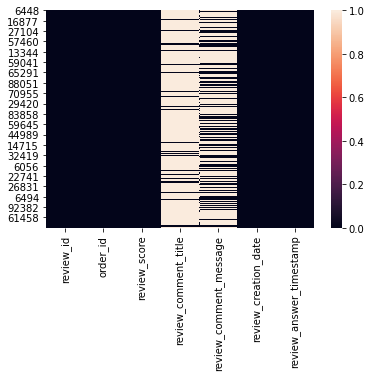

In [10]:
# Visualizando valores faltantes com heatmap
sns.heatmap(data=reviews_sample.isnull());

Confirmamos que há uma grande quantidade de valores faltantes.

In [11]:
# Visualizando alguns comentários
reviews_sample['review_comment_message']

6448     Produto entregue antes do prazo. Serviço e pro...
50680                                                  NaN
814      ótima compra\r\nmas o frete nao compensa,pesa ...
20354                                                  NaN
49224    Produto veio com defeito não funciona, bem vou...
                               ...                        
34197    Já paguei faz tempo, estou precisando é ainda ...
57789                                                  NaN
96663    Entrega recebida bem antestreia do prazo estab...
92710      Ainda não usei o produto mas tudo foi certinho 
12739                                                  NaN
Name: review_comment_message, Length: 40000, dtype: object

In [12]:
# Visualizando alguns títulos dos comentários
reviews_sample['review_comment_title'].unique()

array([nan, 'Produto veio com defeito', 'Super recomendo', ...,
       'Rápido e eficiente', 'Produto entregue em parte',
       'Produto diferente '], dtype=object)

In [13]:
# Número de títulos não únicos
reviews_sample['review_comment_title'].nunique()

2129

In [14]:
# Contagem dos scores
reviews_sample['review_score'].value_counts()

5    23150
4     7565
1     4776
3     3262
2     1247
Name: review_score, dtype: int64

Podemos ainda fazer um histograma para verificar a ocorrência dos scores.

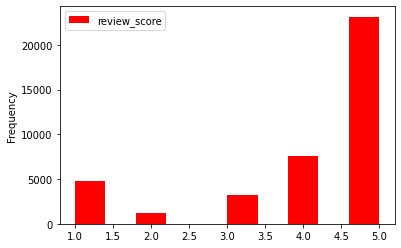

In [15]:
# # Plotando histograma
reviews_sample.plot(kind='hist', color='r');

### Adicionando coluna para classificação

No dataframe reviews temos a coluna "review_score" que representa as notas (de 1 a 5) para os serviços oferecidos. Neste caso, como queremos criar um classificador binário para os comentários (positivos e negativos) devemos então gerar esta classificação baseado no score dado para cada comentário. Assim, tomaremos o seguinte critério:

- scores 1, 2 e 3: comentário negativo = 0;
- scores 4 e 5: comentário positivo = 1.

Desta forma, adicionaremos a coluna "feedback" com a respectiva classificação para cada comentário.

In [18]:
# Adicionando a coluna "feedback"
reviews_sample['feedback'] = reviews_sample['review_score'].apply(lambda x: 1 if x >= 4 else 0)

In [19]:
# Verificando o dataframe com a nova coluna
reviews_sample

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,feedback
6448,65e87641e147cd476cb45db794709d96,1e6eb05de9f71dd42f9ef81813dce355,5,NaN,Produto entregue antes do prazo. Serviço e pro...,2017-04-19 00:00:00,2017-04-19 21:39:51,1
50680,81cc7b52760844d20c4afeab2c71834c,934d3985d22709473850e6e644a19fea,5,NaN,NaN,2018-01-27 00:00:00,2018-01-30 13:14:50,1
814,397f27a0d2936d02d3447864e0398414,8f15948ef0bdb4709a5801084a564c56,3,NaN,"ótima compra\r\nmas o frete nao compensa,pesa ...",2017-10-20 00:00:00,2017-10-23 18:49:42,0
20354,5835427026f36ce691ad96313bddfe91,61b199f09f9de7776b875cce7c71e649,5,NaN,NaN,2018-05-04 00:00:00,2018-05-04 10:44:20,1
49224,7751f2853341c4c59f589164fc02898c,97c5a4acc0915c5bd17e5a3256693ef6,1,Produto veio com defeito,"Produto veio com defeito não funciona, bem vou...",2018-06-27 00:00:00,2018-06-29 19:39:14,0
...,...,...,...,...,...,...,...,...
34197,ae0c4bea81f7dda866bd1ba12d235213,39d0bd05538b0d573193744390e86223,1,NaN,"Já paguei faz tempo, estou precisando é ainda ...",2018-03-24 00:00:00,2018-03-24 11:04:49,0
57789,c4e29cfc5265e1b2200f063ab60405a7,cecc450aed233004e69538a4ce7f7f37,5,NaN,NaN,2017-05-27 00:00:00,2017-05-30 10:46:00,1
96663,3be4d9828f24b3567084677feff43908,865301eccebb37c03ad8ccd1cb994b2b,5,NaN,Entrega recebida bem antestreia do prazo estab...,2018-04-19 00:00:00,2018-04-21 22:37:50,1
92710,a5e4ad45d1d943c92d14fd0193e8d752,35580ca9f2a84299b3b6c41875ba71a7,5,NaN,Ainda não usei o produto mas tudo foi certinho,2018-04-07 00:00:00,2018-04-08 01:03:13,1


Agora precisamos eliminar as colunas do dataframe que não serão utilizadas. Logo, deixaremos apenas as colunas "review_comment_message" e "feedback".

In [20]:
# Deletando colunas desnecessárias
reviews_sample = reviews_sample.drop(columns=['review_id', 'order_id', 'review_score', 
                                'review_comment_title', 'review_creation_date',	
                                'review_answer_timestamp'], axis=1)

# Visualizando o cabeçalho
reviews_sample.head()

,review_comment_message,feedback
6448,Produto entregue antes do prazo. Serviço e pro...,1
50680,NaN,1
814,"ótima compra\r\nmas o frete nao compensa,pesa ...",0
20354,NaN,1
49224,"Produto veio com defeito não funciona, bem vou...",0


In [ ]:
# Deletando registros com valores faltantes
reviews.dropna(inplace=True)

In [ ]:
# Visualizando o cabeçalho
reviews.head()

,review_comment_message,feedback
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1
9,aparelho eficiente. no site a marca do aparelh...,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,"Vendedor confiável, produto ok e entrega antes...",1


In [ ]:
# Visualizando o novo shape do dataframe
reviews.shape

(41753, 2)

Podemos confirmar que o novo dataframe não tem valores faltantes pelo heatmap.

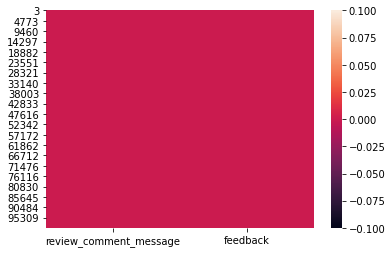

In [ ]:
# Heatmap
sns.heatmap(data=reviews.isnull());

In [ ]:
reviews.isnull().sum()

review_comment_message    0
feedback                  0
dtype: int64

Podemos plotar um histograma da coluna "feedback".

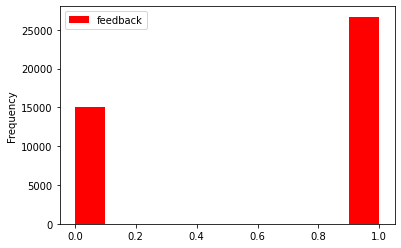

In [ ]:
reviews.plot(kind='hist', color='r');

Podemos ainda adicionar mais uma estatística para entendermos melhor os nossos dados. Neste caso, iremos verificar qual é, em média, o número de caracteres de cada comentário. Criaremos então, outro dataframe para este fim.

In [ ]:
# Criação do novo dataframe
reviews_character_length = reviews.copy() 

# Criando a coluna com o número de caracteres
reviews_character_length['length'] = reviews['review_comment_message'].apply(len)

In [ ]:
# Visualizando o cabeçalho
reviews_character_length

,review_comment_message,feedback,length
3,Recebi bem antes do prazo estipulado.,1,37
4,Parabéns lojas lannister adorei comprar pela I...,1,100
9,aparelho eficiente. no site a marca do aparelh...,1,174
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1,45
15,"Vendedor confiável, produto ok e entrega antes...",1,56
...,...,...,...
99983,Entregou dentro do prazo. O produto chegou em ...,1,91
99990,"O produto não foi enviado com NF, não existe v...",0,125
99996,"Excelente mochila, entrega super rápida. Super...",1,67
99998,Solicitei a compra de uma capa de retrovisor c...,0,198


In [ ]:
# Estatísticas de reviews_character_length
reviews_character_length.describe()

,feedback,length
count,41753.000000,41753.000000
mean,0.638996,70.038632
std,0.480297,54.778207
min,0.000000,1.000000
25%,0.000000,28.000000
50%,1.000000,54.000000
75%,1.000000,97.000000
max,1.000000,208.000000


In [ ]:
# Checando alguns reviews
reviews_character_length.query('length == 1')

,review_comment_message,feedback,length
299,A,1,1
1603,X,1,1
2398,A,0,1
3845,.,1,1
4373,.,1,1
...,...,...,...
92797,.,1,1
94124,,1,1
94943,.,1,1
95538,S,1,1


In [ ]:
# Verificando a quantidade de caracteres únicos
reviews_character_length.query('length == 1')['review_comment_message'].value_counts()

.    51
      9
A     4
?     3
-     3
5     3
😀     2
s     2
m     2
o     2
*     2
👍     2
S     2
X     1
9     1
L     1
B     1
O     1
Y     1
t     1
x     1
0     1
K     1
I     1
👎     1
,     1
4     1
W     1
8     1
Name: review_comment_message, dtype: int64

In [ ]:
# Checando alguns reviews
reviews_character_length.query('length == 208.000000')['review_comment_message'].iloc[0]

'NÃO RECEBI O PRODUTO, O PRODUTO CONSTA COMO ENVIADO PARA O CORREIO DE RIBEIRÃO PRETO. O CORREIO NÃO RECEBEU O PRODUTO. ENVIE VARIAS MENSAGEM PARA A targaryen E NÃO OBTIVE. ESTA targaryen ESTA SUJANDO SEU NOME'

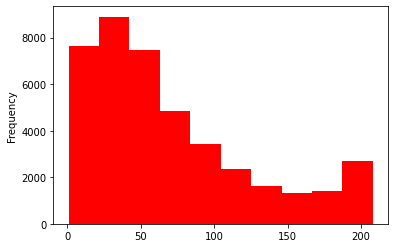

In [ ]:
# Histograma para o tamanho dos reviews
reviews_character_length['length'].plot(kind='hist', color='r');

### Reviews positivos e negativos

Iremos agora gerar dataframes com reviews positivos e negativos e comparar ambos.

In [ ]:
# Dataframe negativo
negative = reviews_character_length.query('feedback == 0')
negative.head()

,review_comment_message,feedback,length
16,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",0,78
19,Péssimo,0,7
29,Não gostei ! Comprei gato por lebre,0,35
32,Sempre compro pela Internet e a entrega ocorre...,0,173
39,Nada de chegar o meu pedido.,0,28


In [ ]:
# Shape
negative.shape

(15073, 3)

In [ ]:
# Visualizando estatística
negative.describe()

,feedback,length
count,15073.0,15073.000000
mean,0.0,97.485570
std,0.0,60.328699
min,0.0,1.000000
25%,0.0,46.000000
50%,0.0,86.000000
75%,0.0,148.000000
max,0.0,208.000000


In [ ]:
# Dataframe positivo
positive = reviews_character_length.query('feedback == 1')
positive.head()

,review_comment_message,feedback,length
3,Recebi bem antes do prazo estipulado.,1,37
4,Parabéns lojas lannister adorei comprar pela I...,1,100
9,aparelho eficiente. no site a marca do aparelh...,1,174
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1,45
15,"Vendedor confiável, produto ok e entrega antes...",1,56


In [ ]:
# Shape
positive.shape

(26680, 3)

In [ ]:
# Visualizando estatística
positive.describe()

,feedback,length
count,26680.0,26680.000000
mean,1.0,54.532346
std,0.0,44.426964
min,1.0,1.000000
25%,1.0,22.000000
50%,1.0,43.000000
75%,1.0,72.000000
max,1.0,207.000000


Vemos que os comentários negativos é, em média, maior do que os positivos e um motivo plausível é a possibilidade de as pessoas com queixas do serviço explicarem mais detalhadamente sua insatisfação.

### Nuvem de palavras

Agora, criaremos duas nuvens de palavra para cada dataframe (positivo e negativo) para entendermos quais palavras mais se destacam em ambos os casos. Para isso, devemos colocar todos os reviews como se fosse uma string apenas. Então, temos o seguinte código com este propósito.

- Reviews positivos

In [ ]:
# Colocando reviews positivos em uma lista
positive_reviews = positive['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
positive_reviews[0:5]

['Recebi bem antes do prazo estipulado.',
 'Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa',
 'aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho',
 'Mas um pouco ,travando...pelo valor ta Boa.\r\n',
 'Vendedor confiável, produto ok e entrega antes do prazo.']

In [ ]:
# Juntando em apenas uma string
sentence_as_one_string = ' '.join(positive_reviews)

Gerando a nuvem de palavras.

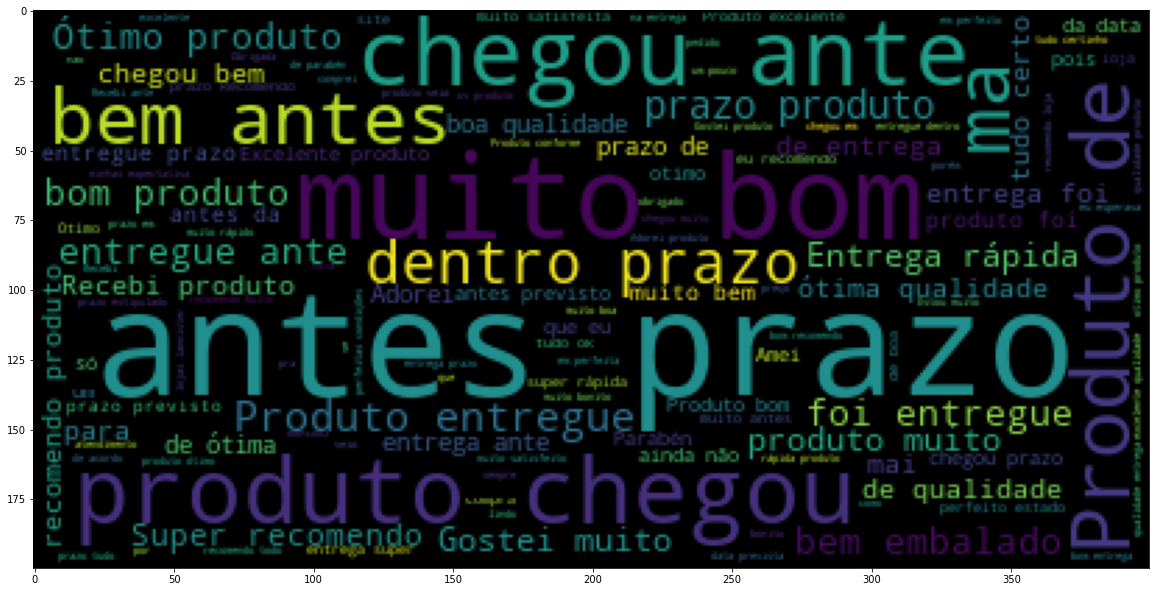

In [ ]:
# Importando a biblioteca
from wordcloud import WordCloud

# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentence_as_one_string));

- Reviews negativos

In [ ]:
# Colocando reviews negativos em uma lista
negative_reviews = negative['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
negative_reviews[0:5]

['GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU',
 'Péssimo',
 'Não gostei ! Comprei gato por lebre',
 'Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.',
 'Nada de chegar o meu pedido.']

In [ ]:
# Juntando em apenas uma string
negative_sentence_as_one_string = ' '.join(negative_reviews)

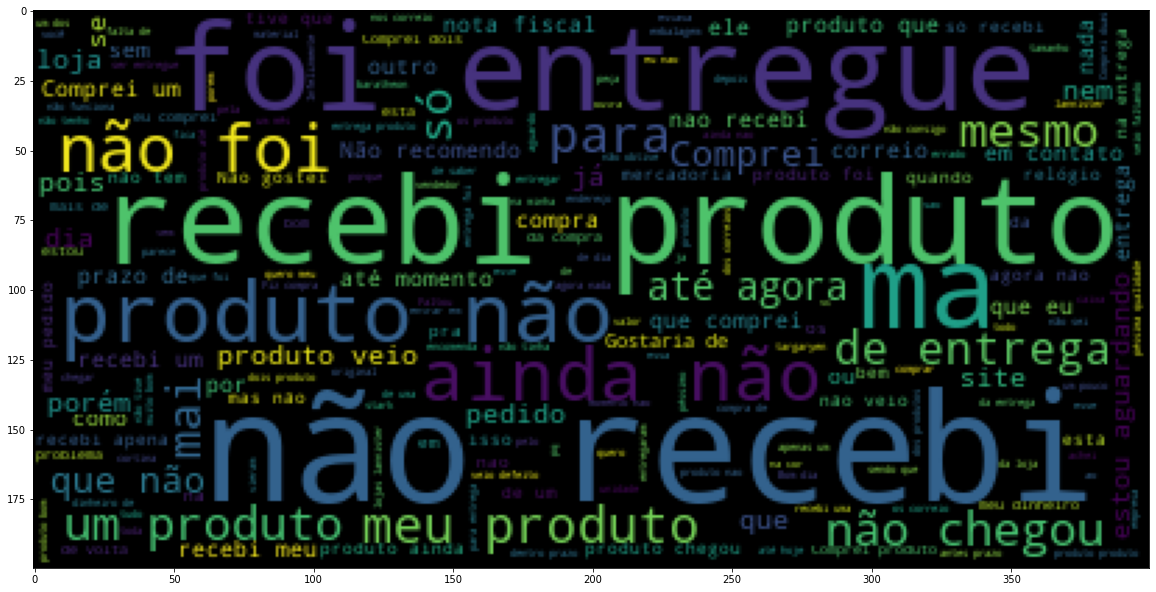

In [ ]:
# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(negative_sentence_as_one_string));

## Remoção de pontuação

Para criar o modelo preditivo de sentimento precisamos tratar os dados (da coluna reviews) e o tratamento neste caso consiste na remoção de pontuação e das chamadas "stop words". Inicialmente iremos tratar a pontuação para, na próxima seção, tratar as stop words.

In [ ]:
# Importando a bibliotecas
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Podemos fazer um teste com um review para termos certeza que o código servirá para nosso propósito.

In [ ]:
# Selecionando um review qualquer do dataframe
test = reviews['review_comment_message'].iloc[200]
test

'A entrega foi realizado muito antes do previsto. \r\nBom produto...estou satisfeita'

In [ ]:
test = re.sub(r'\.+', ' ', test)
test

'A entrega foi realizado muito antes do previsto  \r\nBom produto estou satisfeita'

In [ ]:
test_punct = [letra for letra in test if letra not in string.punctuation]
print(test_punct)

['A', ' ', 'e', 'n', 't', 'r', 'e', 'g', 'a', ' ', 'f', 'o', 'i', ' ', 'r', 'e', 'a', 'l', 'i', 'z', 'a', 'd', 'o', ' ', 'm', 'u', 'i', 't', 'o', ' ', 'a', 'n', 't', 'e', 's', ' ', 'd', 'o', ' ', 'p', 'r', 'e', 'v', 'i', 's', 't', 'o', ' ', ' ', '\r', '\n', 'B', 'o', 'm', ' ', 'p', 'r', 'o', 'd', 'u', 't', 'o', ' ', 'e', 's', 't', 'o', 'u', ' ', 's', 'a', 't', 'i', 's', 'f', 'e', 'i', 't', 'a']


Note que removemos a pontuação do review original. Agora, podemos juntá-lo novamente em uma frase sem tais pontuações.

In [ ]:
# Juntando novamente a frase
test_punct = ''.join(test_punct)
print(test_punct)

A entrega foi realizado muito antes do previsto  
Bom produto estou satisfeita


## Remoção de stop words

Agora iremos remover as stop words, ou seja, aquelas palavras que não contruibuem para o significado positivou ou negativo dos reviews.

In [ ]:
# Importando a biblioteca
import nltk

In [ ]:
# Fazendo download de alguns pacotes
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Como os textos estão em português, precisamos baixar as stop words no mesmo idioma e para isso importaremos uma biblioteca específica do pacote ***nltk***.

In [ ]:
# Importando bibliotecas
from nltk.corpus import stopwords

# Stop words em português
print(stopwords.words('portuguese'))


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [ ]:
# Verificando a quantidade de stop words
len(stopwords.words('portuguese'))

204

Podemos agora testar a remoção de stop words para o review de teste que criamos acima.

In [ ]:
# Removendo stopwords do review de teste
test_punct = [word for word in test_punct.split() if word.lower() not in stopwords.words('portuguese')]

In [ ]:
# Verificando o resultado
test_punct

['entrega', 'realizado', 'antes', 'previsto', 'Bom', 'produto', 'satisfeita']

## Count vectorization (tokenização)

Nesta seção faremos o processo de tokeniação, ou seja, iremos converter cada palavras em números e fazer uma contagem de cada uma delas para verifica sua ocorrência em uma frase.

In [ ]:
# Importando a biblioteca
from sklearn.feature_extraction.text import CountVectorizer

Ulitilizando a frase de testes acima para verificação.

In [ ]:
# Criando um objeto para vetorização
vectorizer = CountVectorizer()

# Aplicando à frase de testes
x = vectorizer.fit_transform(test_punct)

In [ ]:
# Verificando o resultado
x

<7x7 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [ ]:
# Verificando as palavras vetorizadas
vectorizer.get_feature_names()

['antes', 'bom', 'entrega', 'previsto', 'produto', 'realizado', 'satisfeita']

In [ ]:
# Visualizando a matriz resultante
x.toarray()

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1]])

## Pipeline para limpeza de dados

Agora sim iremos aplicar os códigos escritos acima para toda a base de dados.

In [ ]:
# Criando a função
def message_cleaning(message):
  text = re.sub(r'\.+', ' ', message)
  text = [char for char in message if char not in string.punctuation]
  text = ''.join(text)
  text = [word for word in text.split() if word.lower() not in stopwords.words('portuguese')]
  return text

In [ ]:
# Aplicando a função no dataframe
reviews_df_clean = reviews['review_comment_message'].apply(message_cleaning)

In [ ]:
# Visualizando o dataframe
reviews_df_clean

3                  [Recebi, bem, antes, prazo, estipulado]
4        [Parabéns, lojas, lannister, adorei, comprar, ...
9        [aparelho, eficiente, site, marca, aparelho, i...
12                   [pouco, travandopelo, valor, ta, Boa]
15       [Vendedor, confiável, produto, ok, entrega, an...
                               ...                        
99983    [Entregou, dentro, prazo, produto, chegou, con...
99990    [produto, enviado, NF, existe, venda, NF, cert...
99996    [Excelente, mochila, entrega, super, rápida, S...
99998    [Solicitei, compra, capa, retrovisor, celtapri...
99999    [produto, chegou, ja, devolver, pois, defeito,...
Name: review_comment_message, Length: 41753, dtype: object

In [ ]:
# Fazendo a vectorização
vectorizer = CountVectorizer(analyzer=message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(reviews['review_comment_message'])

In [ ]:
# Vendo as palavras únicas
print(vectorizer.get_feature_names())

['0', '00', '000000000000000000000000000', '000000995', '000024453', '000580', '001063', '001689', '003566', '003570', '01', '010', '01022018', '0103', '01032018', '010517', '01052018', '0106', '01062017', '01062018', '0107', '01082018', '0109', '010918', '01092017', '011', '0110', '0111', '01122017', '012', '012495', '015094', '0162017', '0163750232', '0163751255', '0164784672', '0164928917', '0164929116', '0165096389', '0165465041', '0166056315', '0166646383', '0166709005', '0166821151neste', '0167207504', '0167853083', '0168695364', '0168759427', '0169244741', '01UN', '01um', '02', '0201', '020118', '02012018', '02012018nem', '0202', '020218', '02022018', '02032018', '0204', '020418', '02042018', '0205', '020617', '0207', '02072017', '0208', '02082017', '02082018', '0212', '0213', '021385', '02643504565', '02645364747', '02645381563', '02649450934', '026502', '02653047820', '02654859320', '02655871733', '02657469076', '02657530904', '02658094288', '02658697704', '02659395406', '0266

In [ ]:
# Contagem de palavras únicas
len(vectorizer.get_feature_names())

24517

In [ ]:
# Visualizando shape
reviews_countvectorizer.shape

(41753, 24517)